In [16]:
from tqdm import tqdm
import torch
from datetime import datetime
import matplotlib.pyplot as plt 
from dataloader import InsectDatamodule
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np

from model_10 import ResBlock, ResNet

In [17]:
# initialize the datamodule

csv_paths = ['../data/Cicadidae.csv', '../data/Orthoptera.csv']

batch_size = 10
num_workers = 0

n_fft = 1000
hop_length =  147
win_length = int(hop_length * 2)
n_mels = 64

datamodule = InsectDatamodule(csv_paths = csv_paths, batch_size = batch_size, num_workers = num_workers, hop_length = hop_length, n_fft = n_fft, win_length = win_length, n_mels = n_mels)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:46:04<00:00,  9.96s/it]


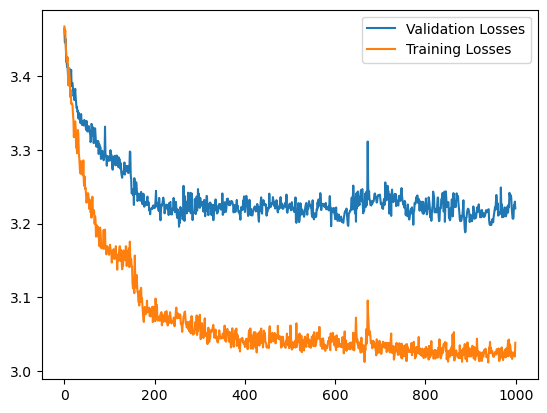

In [4]:
# training the model

epochs = 1000

resnet = ResNet(in_channels=1, out_channels=32, kernel_size=3, n_max_pool=3, n_res_blocks=3, num_classes=datamodule.num_classes).cuda()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.001, weight_decay=0.0)
cross_entropy = torch.nn.CrossEntropyLoss()

train_losses = []
train_losses_epoched = []

valid_losses = []
valid_losses_epoched = []


for epoch in tqdm(range(epochs), ncols=120):
    loss_sum = 0.
    num_losses = 0
    for x, y in datamodule.train_dataloader():
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_hat = resnet(x)
        loss = cross_entropy(y_hat, y.float())
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        num_losses += 1

        train_losses.append(loss.item())
    
    train_losses_epoched.append(loss_sum / num_losses)

    with torch.no_grad():
        loss_sum = 0.
        num_losses = 0
        for x, y in datamodule.val_dataloader():
            x = x.cuda()
            y = y.cuda()
            y_hat = resnet(x)
            loss = cross_entropy(y_hat, y.float())
            loss_sum += loss.item()
            num_losses += 1

            valid_losses.append(loss.item())

        valid_losses_epoched.append(loss_sum / num_losses)

# saving the Model
date = datetime.now().strftime("%Y-%m-%d")

torch.save(resnet.state_dict(), f'model_data/{date}model.pth')

with open(f'model_data/{date}train_losses_epoched.pkl', 'wb') as f:
    pickle.dump(train_losses_epoched, f)

with open(f'model_data/{date}valid_losses_epoched.pkl', 'wb') as f:
    pickle.dump(valid_losses_epoched, f)

# Plotting the losses and saving the plot
plt.plot(valid_losses_epoched, label='Validation Losses')
plt.plot(train_losses_epoched, label='Training Losses')
plt.legend()

plt.savefig(f'model_data/{date}losses_plot.png')

In [18]:
# Initialize the model for testing
resnet = ResNet(in_channels=1, out_channels=32, kernel_size=3, n_max_pool=3, n_res_blocks=3, num_classes=datamodule.num_classes).cuda()

state_dict = torch.load('model_data/2024-04-29model.pth')

resnet.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
# testing the model

resnet.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, y in datamodule.test_dataloader():
        x = x.cuda()
        y = y.cuda()
        y_hat = resnet(x)
        _, predicted = torch.max(y_hat, 1)
        _, true = torch.max(y, 1)

        y_true.extend(true.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

 # Compute confusion matrix

cm = confusion_matrix(y_true, y_pred)

print(cm)       

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0